# Dowload environnement
#### Split in training / validation set

In [1]:
def fpath(algo,prefix=''):
    model_name = algo.__name__
    tb_log_name = prefix + "_"+ f"{model_name}"
    model_path = "./" + prefix + "/" f"{model_name}"
    return model_name, model_path, tb_log_name

In [ ]:
import os
import grid2op
from env_wrapper import Grid2opEnvWrapper

### ENVIRONNEMENT #############################
env_name = "l2rpn_case14_sandbox"
base_path = os.path.expanduser("/Users/mariannelado-roy/data_grid2op")
#################################################

train_dir = os.path.join(base_path, f"{env_name}_train/")
val_dir = os.path.join(base_path, f"{env_name}_val/")
test_dir = os.path.join(base_path, f"{env_name}_test/")

def directories_exist(train_path, val_path, test_path):
    return os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path)

# Make environment
env = grid2op.make(env_name)

if directories_exist(train_dir, val_dir, test_dir):
    print("Directories already exist. Skipping train-val-test split.")
else:
    print("Directories do not exist. Proceeding with train-val-test split.")
    # Perform the split
    try:
        nm_env_train, nm_env_val, nm_env_test = env.train_val_split_random(
            pct_val=10, # 10% validation
            pct_test=10, # 10% test
            add_for_train="train",
            add_for_val="val",
            add_for_test="test"
        )
        print(f"Training environment created: {nm_env_train}")
        print(f"Validation environment created: {nm_env_val}")
        print(f"Test environment created: {nm_env_test}")
    except OSError as e:
        print(f"An error occurred during splitting: {e}")


Directories already exist. Skipping train-val-test split.



# Create the environments


In [ ]:
from grid2op.Reward import RedispReward, L2RPNReward, EpisodeDurationReward, FlatReward, LinesCapacityReward

### REWARDS #############################
reward_function=EpisodeDurationReward
prefix='EpisodeDuration_19dec'
#########################################

env_config = {
    "backend_options": {},
    "env_name": "l2rpn_case14_sandbox", 
    "env_is_test": False,
    # "obs_attr_to_keep": attributes ,
    "act_type": "discrete", 
    "act_attr_to_keep": ["set_line_status", "set_bus"], 
    "reward_class": reward_function, 
}

# Training environnement
train_env_config = env_config.copy()
train_env_config["data_set"] = "train"
train_env = Grid2opEnvWrapper(train_env_config)

# Validation environnement
val_env_config = env_config.copy()
val_env_config["data_set"] = "val"
val_env = Grid2opEnvWrapper(val_env_config)

# Training

In [ ]:
from stable_baselines3 import PPO, DQN, A2C
from sb3_contrib import ARS, QRDQN, TRPO, RecurrentPPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor


########## TRAINING PARAMETERS #################### 
N_TIMESTEP = 200_000
N_EVAL_EPISODES= 10
EVAL_FREQ = 10000
algorithms = [A2C, TRPO]
################################################### 

monitor_env = Monitor(val_env, filename='./monitor_log', allow_early_resets=True)
log_dir = "./tensorboard_logs/"

# Loop over each algorithm
for algo in algorithms:
    # Define the model path and tensorboard log name dynamically
    model_name, model_path, tb_log_name = fpath(algo,prefix)
    
    # Create Call back:
    eval_callback = EvalCallback( 
        eval_env=monitor_env, 
        n_eval_episodes=N_EVAL_EPISODES,
        eval_freq=EVAL_FREQ, 
        log_path = model_path, 
        best_model_save_path=model_path,
        deterministic=True, 
        render=False,
        verbose=0 )


    # Initialize the algorithm with custom hyperparameters
    policy = "MlpPolicy"
    if algo == RecurrentPPO:
        policy =  "MlpLstmPolicy"

    sb3_algo = algo(
        policy,
        train_env,
        verbose=0,
        tensorboard_log=log_dir,
    )

    # Train the model
    sb3_algo.learn(
        total_timesteps=N_TIMESTEP, 
        tb_log_name=tb_log_name,
        callback=eval_callback
    )

    # Save the model
    sb3_algo.save(model_path+'/'+model_name)

    print(f"{model_name} model saved at {model_path}")


KeyboardInterrupt: 

In [ ]:
## IF INTERRUPT

# Save the model
# sb3_algo.save(model_path+'/'+model_name)

# print(f"{model_name} model saved at {model_path}")

RecurrentPPO model saved at ./EpisodeDuration_19dec/RecurrentPPO


#### Look at evaluations

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt


# # Loop over each trained algorithm
# for algo in algorithms:
#     _, model_path, _ =  fpath(algo,prefix)

#     data = np.load(model_path+'/evaluations.npz')

#     results = np.mean(data['results'],axis=1)
#     ep_len = np.mean(data['ep_lengths'],axis=1)
#     t = data['timesteps']

#     plt.figure()
#     plt.plot(t,results/100, label='rewards/100')
#     plt.plot(t,ep_len,label='ep_len')
#     plt.legend()

# Test set

### Compare to baseline agent

In [ ]:
# algorithms=[RecurrentPPO]

In [7]:
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent, TopologyGreedy, PowerLineSwitch, RandomAgent
from agent_wrapper import Grid2opAgentWrapper


# Create test environnement
test_env_config = env_config.copy()
test_env_config["data_set"] = "test"
test_env = Grid2opEnvWrapper(test_env_config)

# Testing parameters
nb_episode_test = 50
seeds_test_env = tuple(range(nb_episode_test))  # Seeds for the environment
seeds_test_agent = tuple(range(nb_episode_test))  # Seeds for the agent

# Trained agents
for algo in algorithms:
    # Define the model path and tensorboard log name dynamically
    model_name, model_path, _ =  fpath(algo,prefix)

    # Load the trained model
    sb3_algo_to_test = algo.load(model_path+'/'+model_name, env=test_env)

    # Convert to grid2op agent
    my_agent = Grid2opAgentWrapper(test_env, sb3_algo_to_test)

    runner = Runner(**test_env._g2op_env.get_params_for_runner(),
                    agentClass=None,
                    agentInstance=my_agent)

    res = runner.run(nb_episode=nb_episode_test,
                    env_seeds=seeds_test_env,
                    agent_seeds=seeds_test_agent,
                    # episode_id=ts_ep_test,
                    add_detailed_output=True,
                    path_save=model_path+"/test"
                    )

# Baseline agents:
baseline_agents= [RandomAgent,DoNothingAgent]
for baseline_agent in baseline_agents : 
    
    model_name, model_path, _ =  fpath(baseline_agent,prefix)
    
    runner = Runner(**test_env._g2op_env.get_params_for_runner(),
                agentClass=baseline_agent)

    res = runner.run(nb_episode=nb_episode_test,
                 env_seeds=seeds_test_env,
                 agent_seeds=seeds_test_agent,
                 # episode_id=ts_ep_test,
                 add_detailed_output=True,
                 path_save=model_path
                 )

# Look at the rewards of some episodes

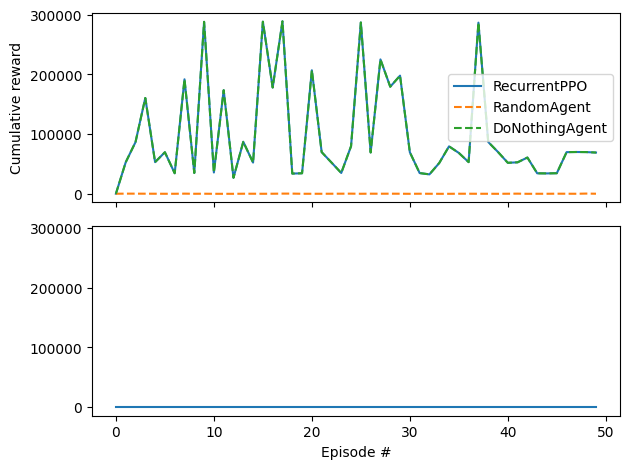

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob


fig, ax = plt.subplots(2,1,sharex=True,sharey=True)
# plt.title('Comparison of Trained agents and Baslines')
ax[1].set_xlabel('Episode #')
ax[0].set_ylabel('Cumulative reward')
cum_rewards = dict()
for algo in algorithms:
    model_name, model_path, _ =  fpath(algo,prefix)
    files = glob.glob(model_path+'/test/*/rewards*')
    n_ep = np.arange(len(files))
    rew_per_ep = []
    for file in files: # 1 file = 1 episode
        rewards = np.load( file)['data']
        rew_per_ep.append(np.nansum(rewards))
    cum_rewards[model_name] = np.array(rew_per_ep)
    ax[0].plot(n_ep, rew_per_ep, '-',label=model_name)
ax[0].legend()

for baseline_agent in baseline_agents : 
    model_name, model_path, _ =  fpath(baseline_agent,prefix)
    files = glob.glob(model_path+'/*/rewards*')
    n_ep = np.arange(len(files))
    rew_per_ep = []
    for file in files: # 1 file = 1 episode
        rewards = np.load( file)['data']
        rew_per_ep.append(np.nansum(rewards))
    cum_rewards[model_name] = np.array(rew_per_ep)
    ax[0].plot(n_ep, rew_per_ep, '--',label=model_name)
ax[0].legend()


# ax[1].plot(n_ep, cum_rewards['RecurrentPPO'] - cum_rewards['DoNothingAgent']  )

plt.tight_layout()
